# Chapter 17 – Autoencoders, GANs, and Diffusion Models

This notebook contains all the sample code and solutions to the exercises in chapter 17.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Warning: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the TF_USE_LEGACY_KERAS environment variable to "1" and import the tf_keras package. This ensures that tf.keras points to tf_keras, which is Keras 2.*.

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

#import tf_keras

And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/generative``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Performing PCA with an Undercomplete Linear Autoencoder
Let's build the Autoencoder...

In [8]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Now let's generate the same 3D dataset as we used in Chapter 8:

In [9]:
# extra code – builds the same 3D dataset as in Chapter 8

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 1ms/step


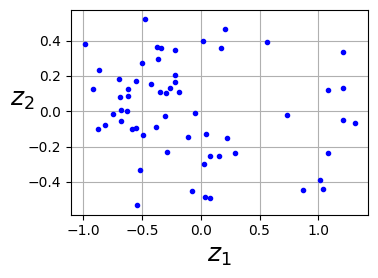

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## Stacked Autoencoders
### Implementing a Stacked Autoencoder Using Keras
Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [12]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [13]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0249 - val_loss: 0.0192
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0180 - val_loss: 0.0173
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 8/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 10/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.013

## Visualizing the Reconstructions
This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

1/1 [==============================] - 0s 38ms/step


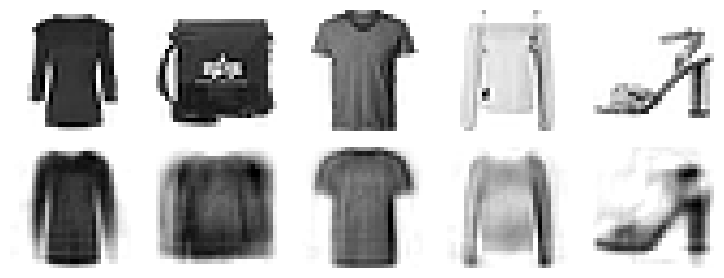

In [14]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

## Visualizing the Fashion MNIST Dataset

In [15]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 475us/step


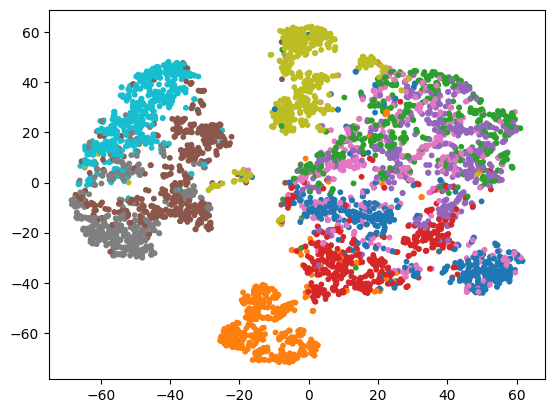

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from this Scikit-Learn example):

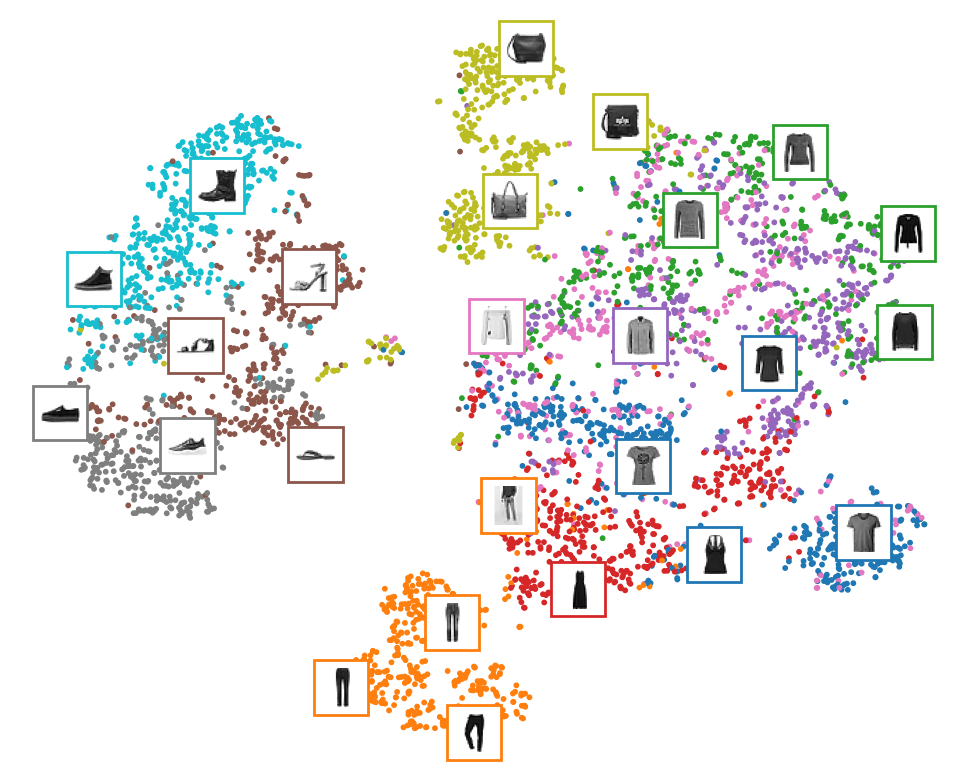

In [17]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights
It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [18]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [19]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0245 - val_loss: 0.0179
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 10/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.013

1/1 [==============================] - 0s 45ms/step


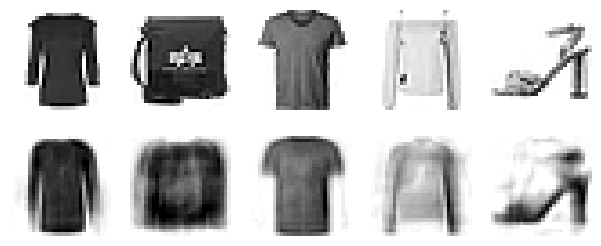

In [20]:
# extra code – plots reconstructions
plot_reconstructions(tied_ae)
plt.show()


## Extra Material – Training one Autoencoder at a Time

In [21]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [22]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0202 - val_loss: 0.0131
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.008

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [23]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 40ms/step


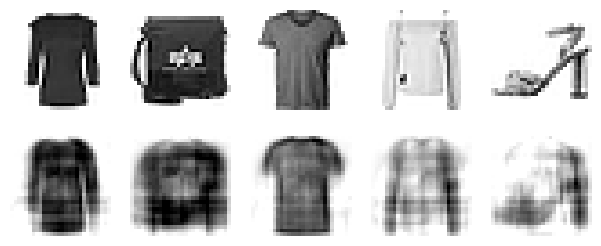

In [24]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [25]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0175 - val_loss: 0.0160
Epoch 2/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 3/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0144 - val_loss: 0.0151
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 5/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0135 - val_loss: 0.0135


1/1 [==============================] - 0s 34ms/step


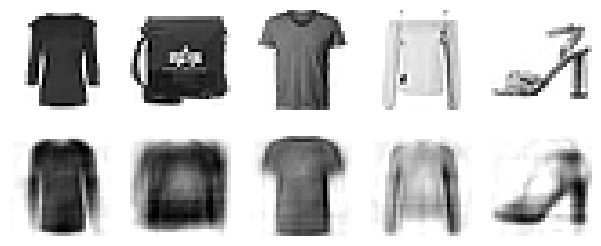

In [26]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders
Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [27]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0330 - val_loss: 0.0223
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0208 - val_loss: 0.0205
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0178 - val_loss: 0.0189
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 9/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 10/10
1719/1719 [==============================] - 11s 6ms/step - l

1/1 [==============================] - 0s 91ms/step


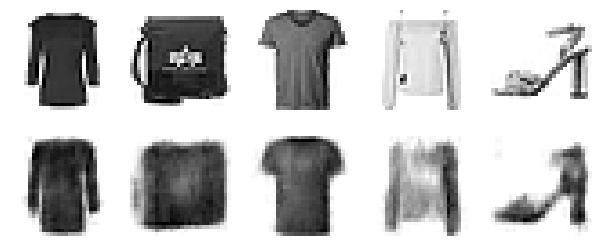

In [28]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

## Extra Material – Recurrent Autoencoders
Let's treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions:

In [29]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())

In [30]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 20s 10ms/step - loss: 0.0292 - val_loss: 0.0222
Epoch 2/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0191 - val_loss: 0.0177
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0163 - val_loss: 0.0180
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 5/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 6/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 9/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 10/10
1719/1719 [==============================] - 18s 11m

1/1 [==============================] - 0s 428ms/step


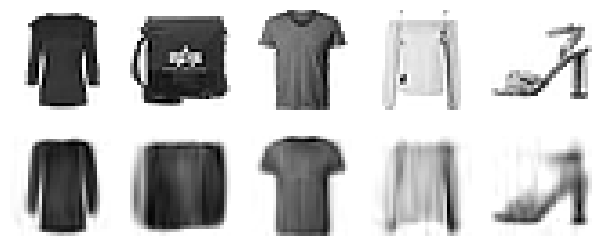

In [31]:
plot_reconstructions(recurrent_ae)
plt.show()

## Denoising Autoencoders
Using dropout:

In [32]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0292 - val_loss: 0.0231
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0232 - val_loss: 0.0210
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0219 - val_loss: 0.0202
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0211 - val_loss: 0.0194
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0205 - val_loss: 0.0190
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0201 - val_loss: 0.0187
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0198 - val_loss: 0.0184
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0196 - val_loss: 0.0181
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0194 - val_loss: 0.0181
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.019

1/1 [==============================] - 0s 34ms/step


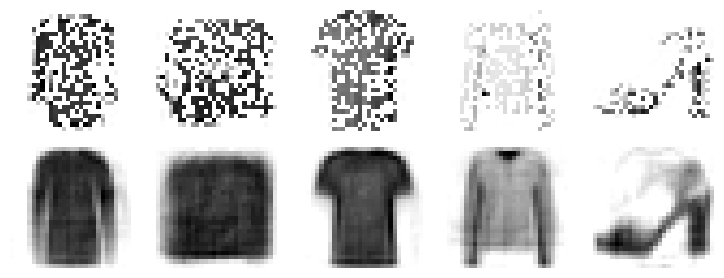

In [33]:
# extra code – this cell generates and saves Figure 17–9
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()


## Sparse Autoencoder
Let's use the sigmoid activation function in the coding layer. Let's also add 
 regularization to it: to do this, we add an ```ActivityRegularization``` layer after the coding layer. Alternatively, we could add ```activity_regularizer=tf.keras.regularizers.l1(1e-4)``` to the coding layer itself.

In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0296 - val_loss: 0.0206
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.011

1/1 [==============================] - 0s 38ms/step


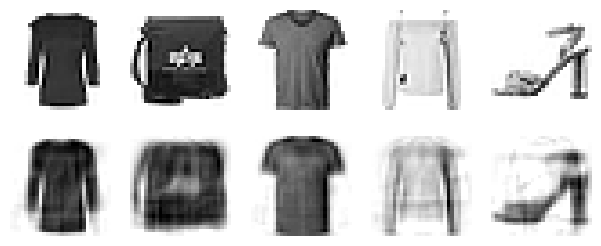

In [35]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()